In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from openpyxl import load_workbook

In [2]:
PATH2ROOT = "../../"
sbj_num = 10
smp_dir = PATH2ROOT + f"subjects/{sbj_num}/smp/"

In [3]:
fps = 15
T = 1/fps
t_discard = 0.3
x_merge = 0.25/2  # pxr  --> pixel ratio (pixel/screen_width)
y_merge = 0.33/2  # pxr
vx_thr = 2.5  # pxr/sec
vy_thr = 2.5  # pxr/sec
v_scale_show = 10

In [4]:
with open(smp_dir + "t_vec.pickle", 'rb') as f:
    t = pickle.load(f)
with open(smp_dir + "y_prd.pickle", 'rb') as f:
    et = pickle.load(f)
n_smp_all = et.shape[0]
print(n_smp_all)

465


In [5]:
wb = load_workbook(smp_dir + "EYE TRACK.xlsx")
sheet = wb["Sheet"]
i = 1
et_xl = []
while sheet[f"A{i}"].value != None:
    if i != 1:
        et_xl.append(
            [int(sheet[f"A{i}"].value),
             float(sheet[f"B{i}"].value),
             float(sheet[f"C{i}"].value),
             float(sheet[f"D{i}"].value),
             sheet[f"E{i}"].value]
        )
    i += 1
n_smp_all = len(et_xl)

In [6]:
i = 0
t_mat_seq = []
et_mat_seq = []
while i < n_smp_all:
    if (et_xl[i][4] == "start") or (et_xl[i][4] == "Start"):
        t1 = []
        et1 = []
        j = 0
        while True:
            t1.append([et_xl[i+j][1]])
            et1.append([et_xl[i+j][2], et_xl[i+j][3]])
            if et_xl[i+j][4] == "stop" or et_xl[i+j][4] == "Stop":
                break
            j += 1
        t_mat_seq.append(np.array(t1).reshape((len(t1),)))
        et_mat_seq.append(np.array(et1))
        i += j
    i += 1

In [7]:
t_mat_in = []
et_mat_in = []
for (t1, et1) in zip(t_mat_seq, et_mat_seq):
    looking_in = et1[:, 0] != -1
    t_mat_in.append(t1[looking_in])
    et_mat_in.append(et1[looking_in])

In [8]:
t = t_mat_seq[0]
et = et_mat_seq[0]
for (i, t1) in enumerate(t_mat_seq):
    if i == 0:
        continue
    t = np.concatenate([t, t1])
    et = np.concatenate([et, et_mat_seq[i]])

449


Text(0.5, 1.0, 'Eye track on screen')

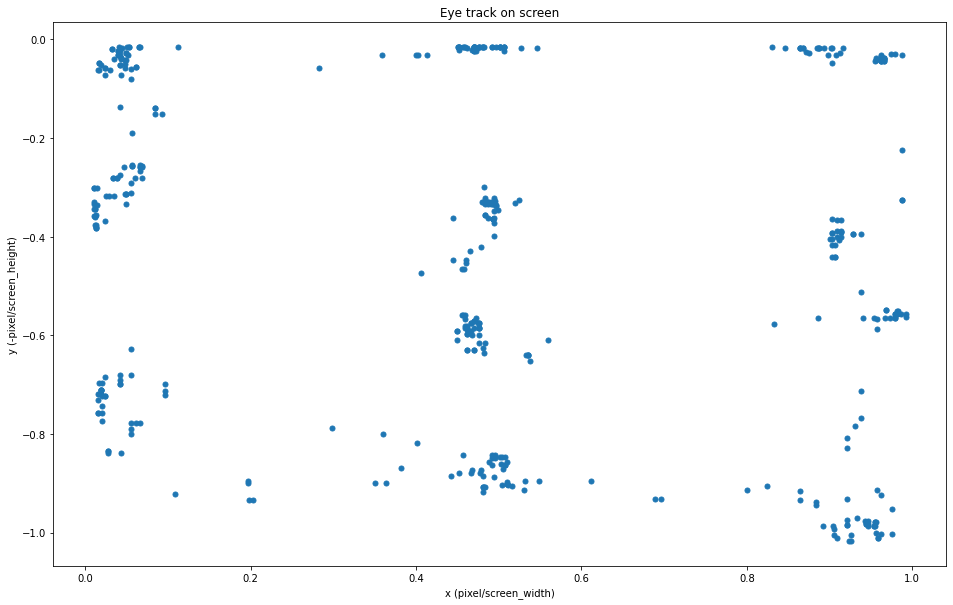

In [41]:
looking_in = et[:, 0] != -1
t_in = t[looking_in]
et_in = et[looking_in]
print(len(et_in))
plt.figure(figsize=(16, 10))
plt.plot(np.array(et_in[:, 0]), -np.array(et_in[:, 1]), 'o', markersize=5)
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Eye track on screen")

In [10]:
t_mat = []
et_mat = []
for (t1, et1) in zip(t_mat_seq, et_mat_seq):
    n_smp1 = t1.shape[0]
    blinking_out = (et1[:, 0] == -1)
    t_mat1 = []
    et_mat1 = []
    i = 0
    while i < (n_smp1):
        t0 = []
        bo_vec = []
        in_vec = []
        now = blinking_out[i]
        t0.append(t1[i])
        if now:
            bo_vec.append(et1[i])
        else:
            in_vec.append(et1[i])
        j = 1
        if (i+j) < n_smp1:
            while blinking_out[i+j] == now:
                t0.append(t1[i+j])
                if now:
                    bo_vec.append(et1[i+j])
                else:
                    in_vec.append(et1[i+j])
                j += 1
                if (i+j) >= n_smp1:
                    break
        t_mat1.append(np.array(t0))
        if now:
            et_mat1.append(np.array(bo_vec))
        else:
            et_mat1.append(np.array(in_vec))
        i += j
    t_mat.append(t_mat1)
    et_mat.append(et_mat1)

In [11]:
print(np.zeros((1, 2)))

[[0. 0.]]


In [12]:
saccades = []
vet_mat = []
for (t2, et2) in zip(t_mat, et_mat):
    saccades1 = []
    vet_mat1 = []
    for (t1, et1) in zip(t2, et2):
        if et1[0, 0] != -1:
            if et1.shape[0] == 1:
                vet1 = np.zeros((1,2))
                s1 = [None]
            else:
                vet1 = et1.copy()
                vet1[1:, 0] = (et1[1:, 0] - et1[:-1, 0]) / (t1[1:] - t1[:-1])
                vet1[1:, 1] = (et1[1:, 1] - et1[:-1, 1]) / (t1[1:] - t1[:-1])
                vet1[0] = vet1[1]

                s1 = ((vet1[:, 0]>vx_thr)+(vet1[:, 0]<-vx_thr))+((vet1[:, 1]>vy_thr)+(vet1[:, 1]<-vy_thr))
        else:
            et_shape = et1.shape[0]
            vet1 = np.zeros(et1.shape)
            s1 = np.array([None] * et_shape)
        vet_mat1.append(vet1)
        saccades1.append(s1)
    saccades.append(saccades1)
    vet_mat.append(vet_mat1)

In [13]:
vet4 = []
for vet3 in vet_mat:
    vet2 = vet3[0].copy()
    for (i, vet1) in enumerate(vet3):
        if i == 0:
            continue
        vet2 = np.concatenate([vet2, vet1], 0)
    vet4.append(np.array(vet2))

vet = vet4[0]
for (i, vet1) in enumerate(vet4):
    if i == 0:
        continue
    vet = np.concatenate([vet, vet1])

Text(0.5, 1.0, 'Eye track - Eye track speed - X direction')

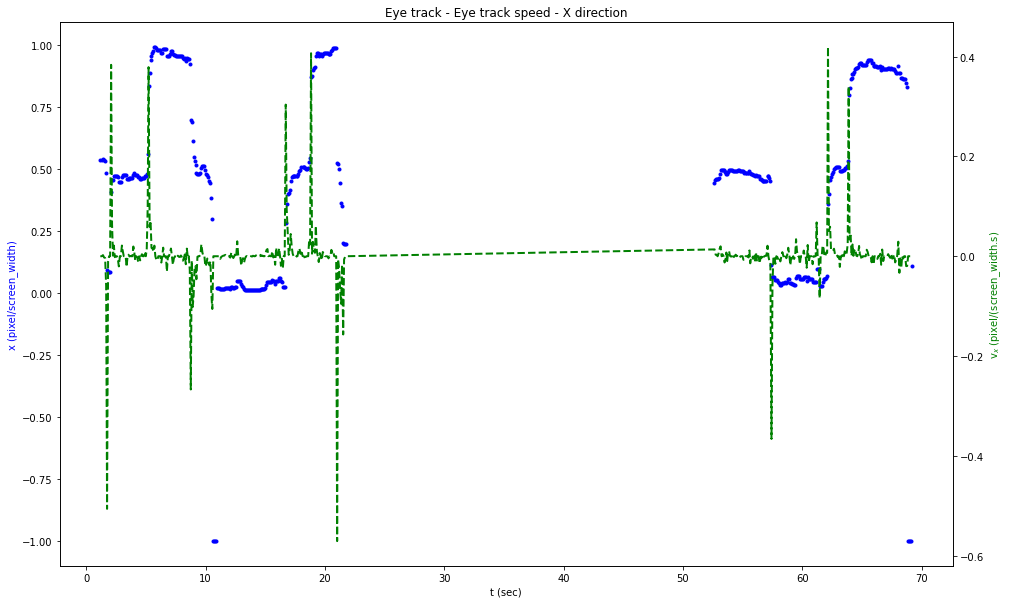

In [14]:
_, ax = plt.subplots(figsize=(16, 10))
ax2 = ax.twinx()
ax.plot(t, et[:, 0], 'o', markersize=3, color='b')
ax2.plot(t, vet[:, 0]/v_scale_show, linestyle='--', color='g', linewidth=2)
ax.set_xlabel("t (sec)")
ax.set_ylabel("x (pixel/screen_width)", color='b')
ax2.set_ylabel("v" + r"$_x$" + " (pixel/(screen_width.s)", color='g')
plt.title("Eye track - Eye track speed - X direction")

Text(0.5, 1.0, 'Eye track - Eye track speed - Y direction')

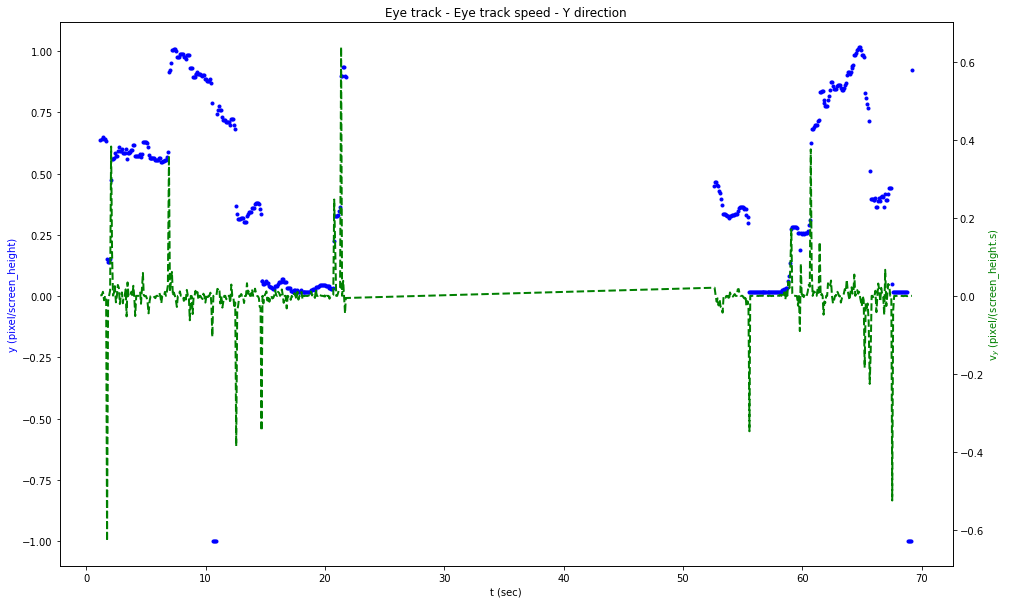

In [15]:
_, ax = plt.subplots(figsize=(16, 10))
ax2 = ax.twinx()
ax.plot(t, et[:, 1], 'o', markersize=3, color='b')
ax2.plot(t, vet[:, 1]/v_scale_show, linestyle='--', color='g', linewidth=2)
ax.set_xlabel("t (sec)")
ax.set_ylabel("y (pixel/screen_height)", color='b')
ax2.set_ylabel("v" + r"$_y$" + " (pixel/(screen_height.s)", color='g')
plt.title("Eye track - Eye track speed - Y direction")

In [16]:
sac_mat_new = []
t_mat_new = []
et_mat_new = []
for (t_mat1, et_mat1, saccades1) in zip(t_mat, et_mat, saccades):
    k = 0
    sac_mat_new1 = []
    t_mat_new1 = []
    et_mat_new1 = []
    for (t1, et1, sac1) in zip(t_mat1, et_mat1, saccades1):
        if et1[0, 0] != -1:
            n_smp = t1.shape[0]
            i = 0
            while i < (n_smp):
                s0 = []
                t0 = []
                et0 = []
                now = sac1[i]
                s0.append(sac1[i])
                t0.append(t1[i])
                et0.append(et1[i])
                j = 1
                if (i+j) < n_smp:
                    while sac1[i+j] == now:
                        s0.append(sac1[i+j])
                        t0.append(t1[i+j])
                        et0.append(et1[i+j])
                        j += 1
                        if (i+j) >= n_smp:
                            break
                sac_mat_new1.append(np.array(s0))
                t_mat_new1.append(np.array(t0))
                et_mat_new1.append(np.array(et0))
                i += j
        else:
            sac_mat_new1.append(sac1)
            t_mat_new1.append(t1)
            et_mat_new1.append(et1)
    sac_mat_new.append(sac_mat_new1)
    t_mat_new.append(t_mat_new1)
    et_mat_new.append(et_mat_new1)

In [17]:
fix = []
k = 0
for (sac_mat_new1, t_mat_new1, et_mat_new1) in zip(sac_mat_new, t_mat_new, et_mat_new):
    fix1 = []
    for (s1, t1, et1) in zip(sac_mat_new1, t_mat_new1, et_mat_new1):
        sac_shp = s1.shape
        if s1[0] == False:
            if not s1[0]:
                fix1.append([k,
                             sac_shp[0],
                             t1[0],
                             round(t1[-1]-t1[0], 2),
                             round(et1[:, 0].mean(), 4),
                             round(et1[:, 1].mean(), 4)])
        k += sac_shp[0]
    fix.append(np.array(fix1))

Text(0.5, 0.92, 'Eye track respect to time')

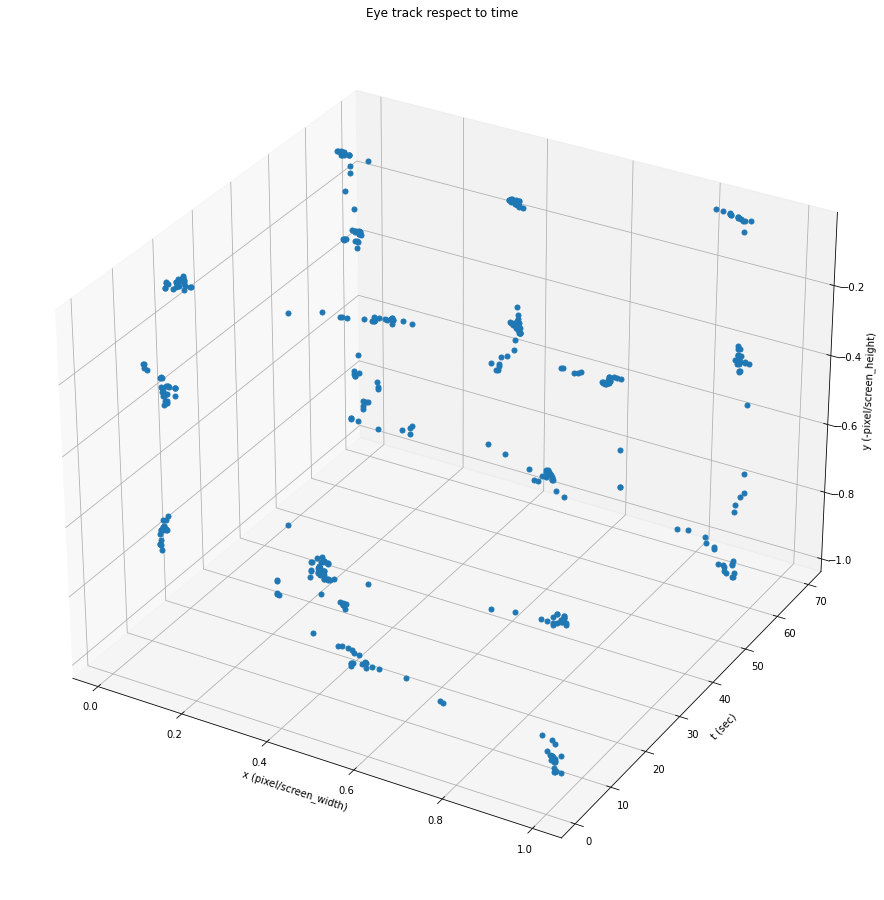

In [18]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')
ax.plot(et_in[:, 0], t_in, -np.array(et_in[:, 1]), 'o', markersize=5)
ax.set_xlabel("x (pixel/screen_width)")
ax.set_ylabel("t (sec)")
ax.set_zlabel("y (-pixel/screen_height)")
plt.title("Eye track respect to time")

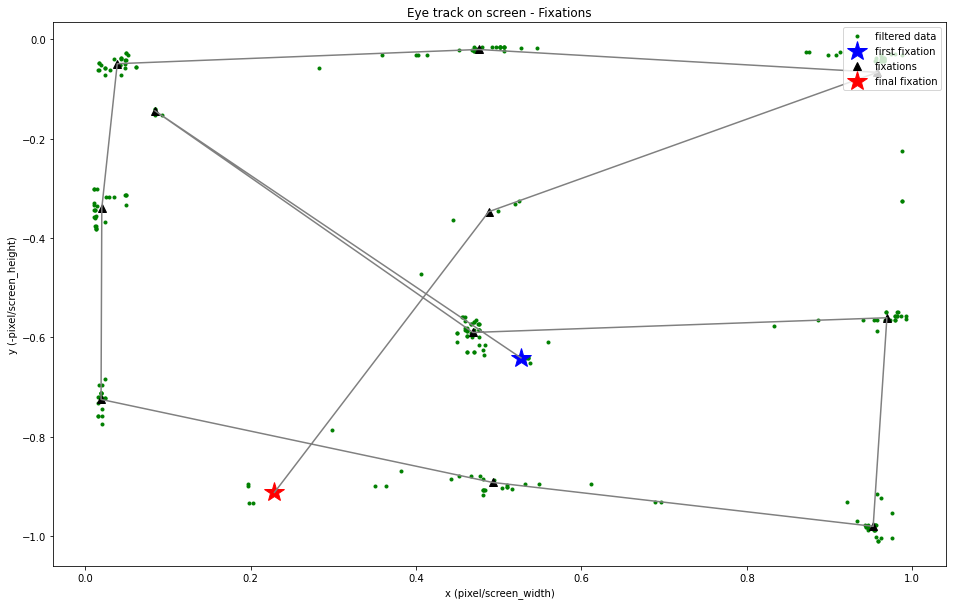

In [19]:
n_seq = 0
fs_ind = []
fs_x = []
fs_y = []
for f in fix[n_seq]:
    fs_ind.append(f[0])
    fs_x.append(f[4])
    fs_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(
    np.array(et_mat_in[n_seq][:, 0]),
    -np.array(et_mat_in[n_seq][:, 1]),
    'o', markersize=3,
    label="filtered data",
    color="green"
)
plt.plot(np.array(fs_x[0]), -np.array(fs_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fs_x[1:-1]), -np.array(fs_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fs_x[-1]), -np.array(fs_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fs_x), -np.array(fs_y), color='gray')
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Eye track on screen - Fixations")
plt.legend(loc="upper right")

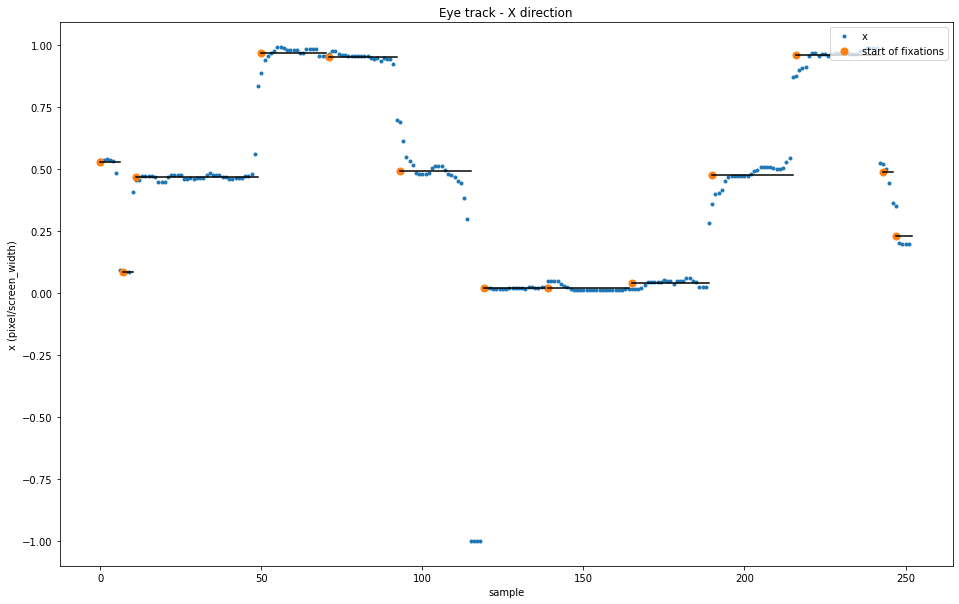

In [20]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 0], 'o', markersize=3, label="x")
plt.plot(fs_ind, fs_x, 'o', label="start of fixations", markersize=7)
for f in fix[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x,color="black", linewidth=1.5)
plt.title("Eye track - X direction")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

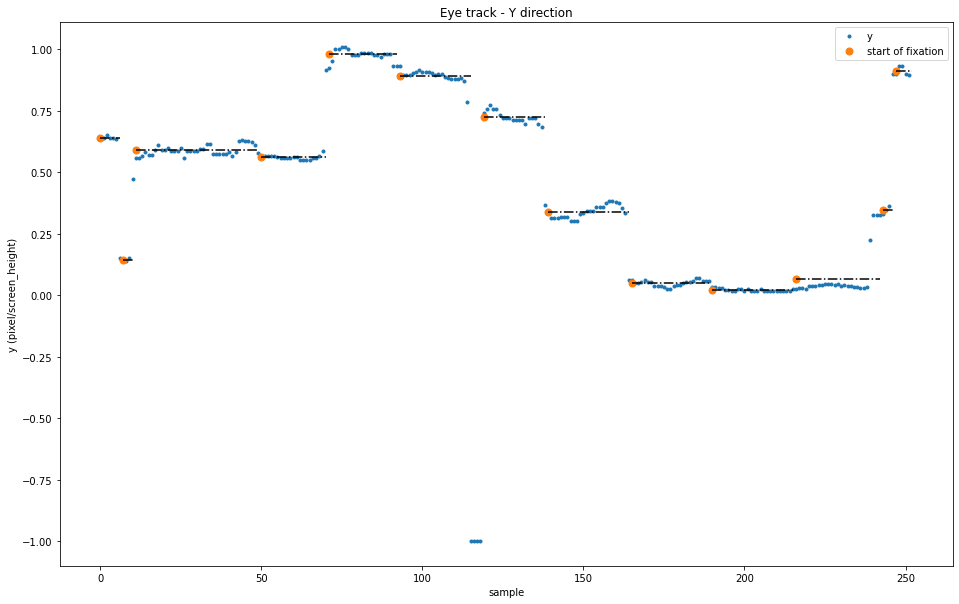

In [21]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 1], 'o', markersize=3, label="y")
plt.plot(fs_ind, fs_y, 'o', label="start of fixation", markersize=7)
for f in fix[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - Y direction")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_height)")
plt.legend(loc="upper right")

In [22]:
print(fix[0][-1])

[2.4700e+02 5.0000e+00 2.1442e+01 3.2000e-01 2.2900e-01 9.1220e-01]


In [23]:
n_monitors_data = 1
fix_mrg_one = []
for fix1 in fix:
    fix_mrg1 = []
    n_fix = len(fix1)
    i = 0
    while i < n_fix:
        f_new = fix1[i]
        j = 1
        while (i+j) < n_fix:
            fj = fix1[i+j]
            fj_d = ((fj[4]-f_new[4])/(x_merge/n_monitors_data))**2+((fj[5]-f_new[5])/(y_merge))**2
            if fj_d < 1:
                f_new = [f_new[0],
                         f_new[1] + fj[1],
                         f_new[2],
                         round(f_new[3] + fj[3], 2),
                         round((f_new[4]*f_new[1]+fj[4]*fj[1])/(f_new[1]+fj[1]), 4),
                         round((f_new[5]*f_new[1]+fj[5]*fj[1])/(f_new[1]+fj[1]), 4)]
                if (i+j) == n_fix-1:
                    fix_mrg1.append(f_new)
                not_joined = False
            else:
                fix_mrg1.append(f_new)
                not_joined = True
                break
            j += 1
        i += j
    if not_joined:
        fix_mrg1.append(fix1[-1])
        
    fix_mrg_one.append(np.array(fix_mrg1))

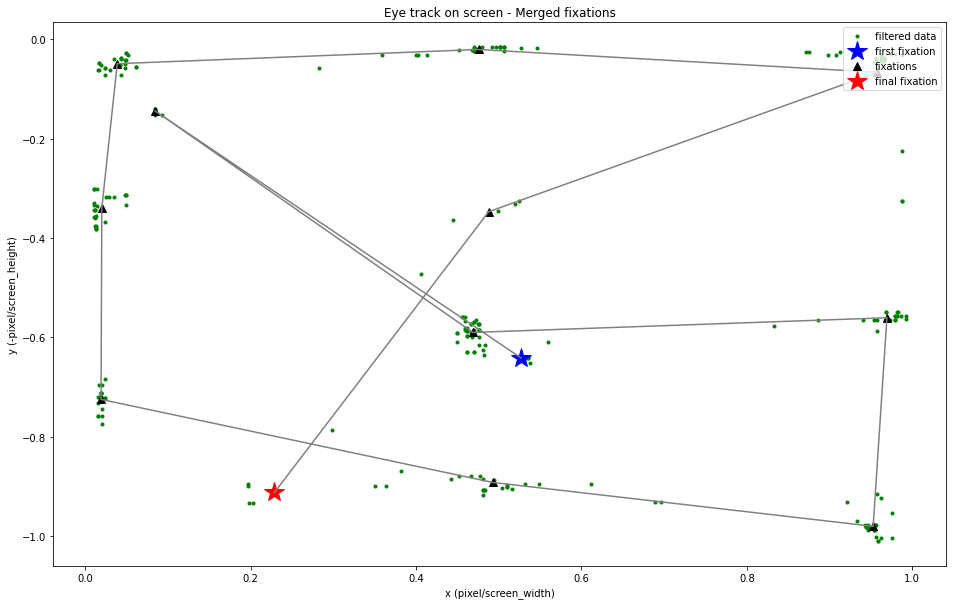

In [24]:
n_seq = 0
fms1_ind = []
fms1_x = []
fms1_y = []
for f in fix_mrg_one[n_seq]:
    fms1_ind.append(f[0])
    fms1_x.append(f[4])
    fms1_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(
    np.array(et_mat_in[n_seq][:, 0]),
    -np.array(et_mat_in[n_seq][:, 1]),
    'o', markersize=3,
    label="filtered data",
    color="green"
)
plt.plot(np.array(fms1_x[0]), -np.array(fms1_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fms1_x[1:-1]), -np.array(fms1_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fms1_x[-1]), -np.array(fms1_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fms1_x), -np.array(fms1_y), color='gray')
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Eye track on screen - Merged fixations")
plt.legend(loc="upper right")

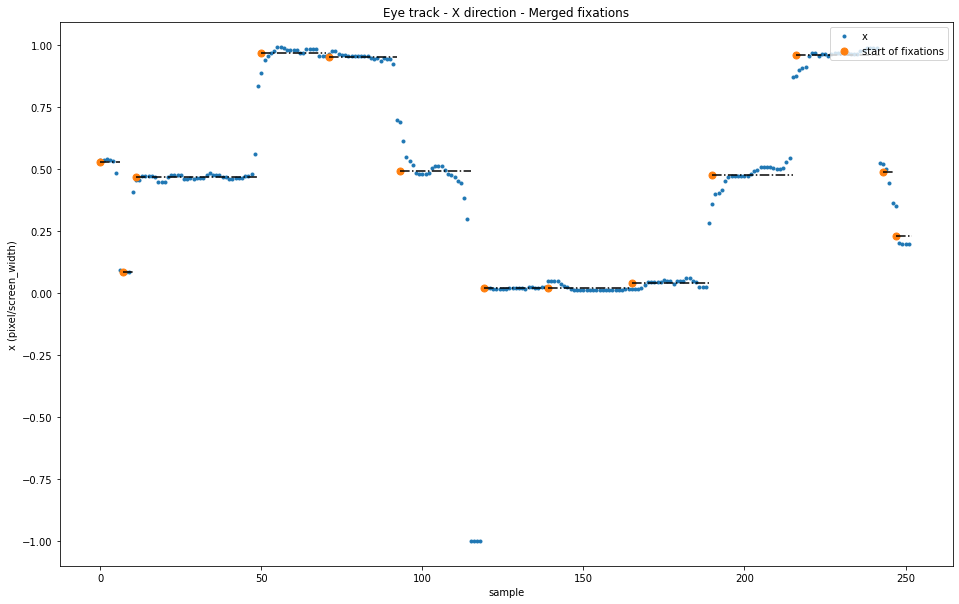

In [25]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 0], 'o', markersize=3, label="x")
plt.plot(fms1_ind, fms1_x, 'o', label="start of fixations", markersize=7)
for f in fix_mrg_one[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - X direction - Merged fixations")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

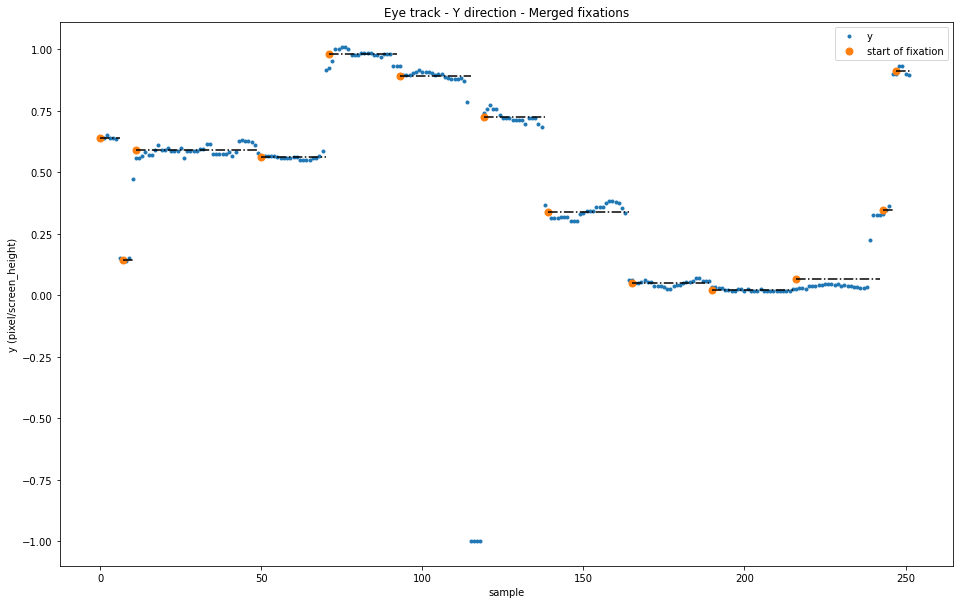

In [26]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 1], 'o', markersize=3, label="y")
plt.plot(fms1_ind, fms1_y, 'o', label="start of fixation", markersize=7)
for f in fix_mrg_one[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - Y direction - Merged fixations")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_height)")
plt.legend(loc="upper right")

In [27]:
fix_dcd = []
for fix_mrg1 in fix_mrg_one:
    fix_dcd1 = []
    for f in fix_mrg1:
        if f[3] >= t_discard:
            fix_dcd1.append(f)
    fix_dcd.append(np.array(fix_dcd1))

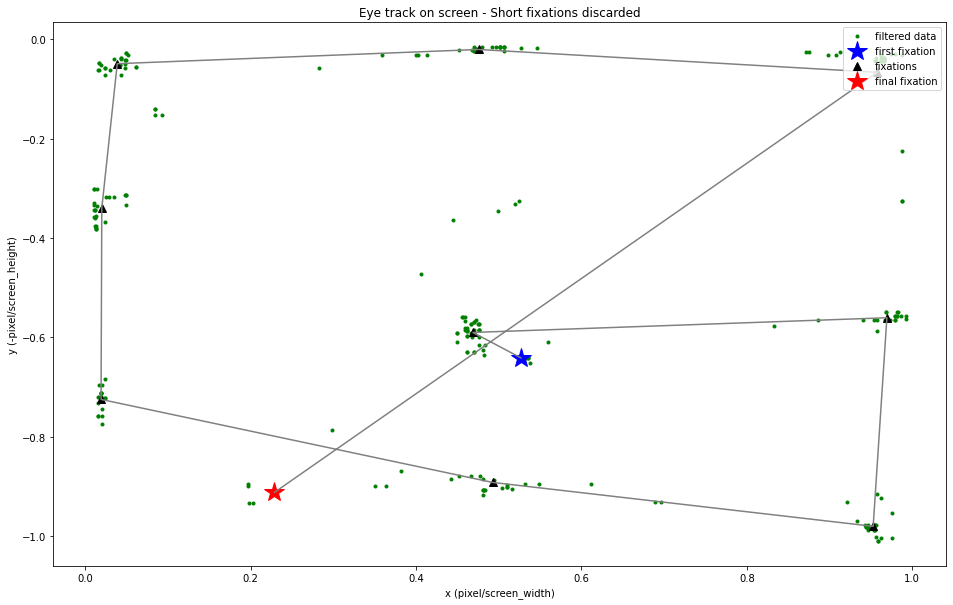

In [28]:
n_seq = 0
fds_ind = []
fds_x = []
fds_y = []
for f in fix_dcd[n_seq]:
    fds_ind.append(f[0])
    fds_x.append(f[4])
    fds_y.append(f[5])
plt.figure(figsize=(16, 10))
plt.plot(
    np.array(et_mat_in[n_seq][:, 0]),
    -np.array(et_mat_in[n_seq][:, 1]),
    'o', markersize=3,
    label="filtered data",
    color="green"
)
plt.plot(np.array(fds_x[0]), -np.array(fds_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fds_x[1:-1]), -np.array(fds_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fds_x[-1]), -np.array(fds_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fds_x), -np.array(fds_y), color='gray')
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Eye track on screen - Short fixations discarded")
plt.legend(loc="upper right")

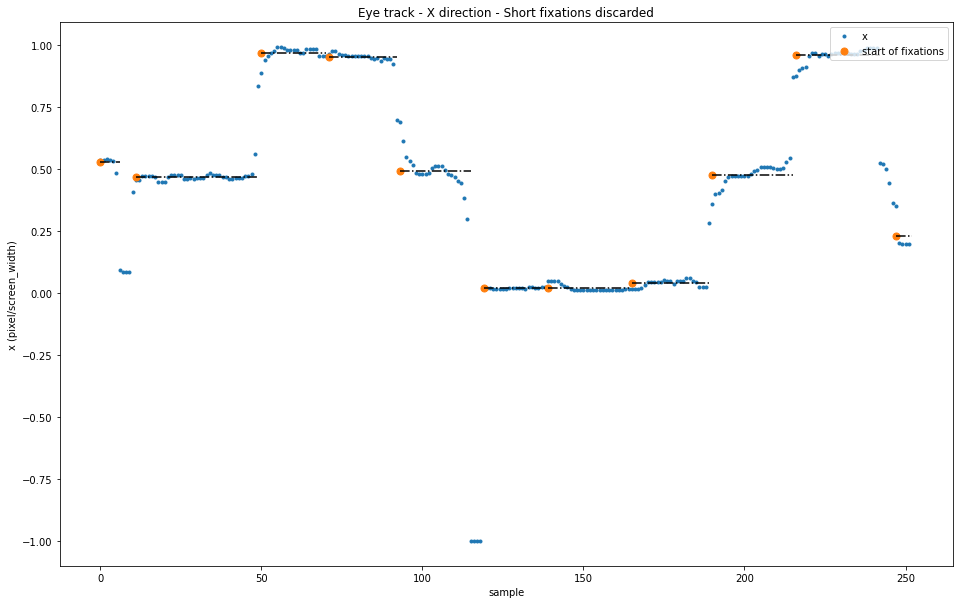

In [29]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 0], 'o', markersize=3, label="x")
plt.plot(fds_ind, fds_x, 'o', label="start of fixations", markersize=7)
for f in fix_dcd[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - X direction - Short fixations discarded")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

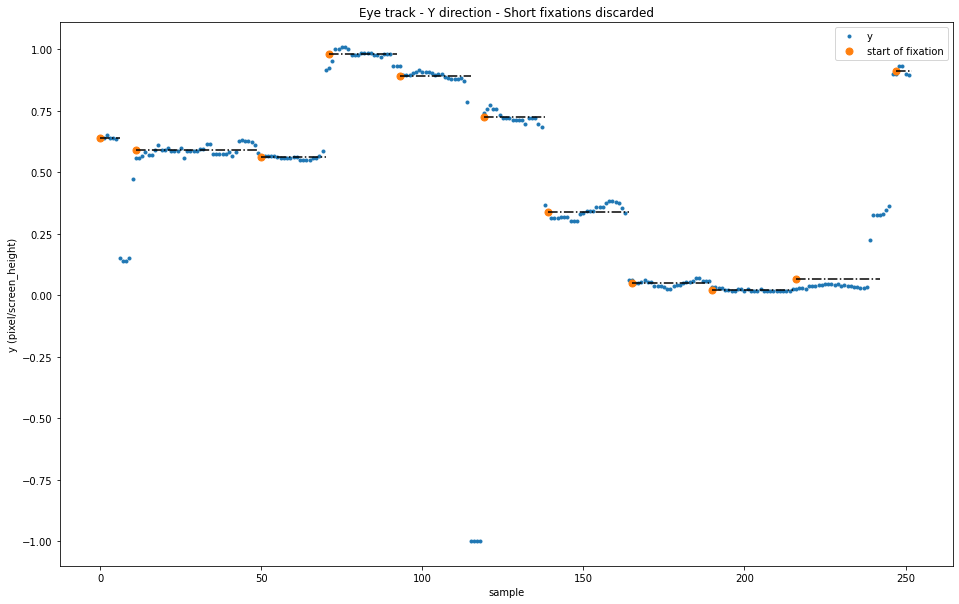

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 1], 'o', markersize=3, label="y")
plt.plot(fds_ind, fds_y, 'o', label="start of fixation", markersize=7)
for f in fix_dcd[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - Y direction - Short fixations discarded")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_height)")
plt.legend(loc="upper right")

In [31]:
fix_mrg_two = []
for fix1 in fix_dcd:
    fix_mrg1 = []
    n_fix = len(fix1)
    i = 0
    while i < n_fix:
        f_new = fix1[i]
        j = 1
        while (i+j) < n_fix:
            fj = fix1[i+j]
            fj_d = ((fj[4]-f_new[4])/(x_merge/n_monitors_data))**2+((fj[5]-f_new[5])/(y_merge))**2
            if fj_d < 1:
                f_new = [f_new[0],
                         f_new[1] + fj[1],
                         f_new[2],
                         round(f_new[3] + fj[3], 2),
                         round((f_new[4]*f_new[1]+fj[4]*fj[1])/(f_new[1]+fj[1]), 4),
                         round((f_new[5]*f_new[1]+fj[5]*fj[1])/(f_new[1]+fj[1]), 4)]
                if (i+j) == n_fix-1:
                    fix_mrg1.append(f_new)
                not_joined = False
            else:
                fix_mrg1.append(f_new)
                not_joined = True
                break
            j += 1
#             if (i+j) >= n_fix:
#                 break
        i += j
    if not_joined:
        fix_mrg1.append(fix1[-1])
        
    fix_mrg_two.append(np.array(fix_mrg1))

In [32]:
print(fix_mrg_two)

[array([[0.0000e+00, 4.4000e+01, 1.1870e+00, 3.4800e+00, 4.7680e-01,
        5.9730e-01],
       [5.0000e+01, 2.0000e+01, 5.3190e+00, 1.5300e+00, 9.6940e-01,
        5.6070e-01],
       [7.1000e+01, 2.1000e+01, 7.0190e+00, 1.6600e+00, 9.5280e-01,
        9.8060e-01],
       [9.3000e+01, 2.2000e+01, 8.8500e+00, 1.7200e+00, 4.9260e-01,
        8.9220e-01],
       [1.1900e+02, 1.9000e+01, 1.0990e+01, 1.5000e+00, 1.9300e-02,
        7.2510e-01],
       [1.3900e+02, 2.5000e+01, 1.2657e+01, 1.9600e+00, 2.0200e-02,
        3.3990e-01],
       [1.6500e+02, 2.4000e+01, 1.4774e+01, 1.8600e+00, 3.8900e-02,
        4.9200e-02],
       [1.9000e+02, 2.5000e+01, 1.6802e+01, 1.9600e+00, 4.7590e-01,
        2.0600e-02],
       [2.1600e+02, 2.6000e+01, 1.8924e+01, 2.0200e+00, 9.5790e-01,
        6.6600e-02],
       [2.4700e+02, 5.0000e+00, 2.1442e+01, 3.2000e-01, 2.2900e-01,
        9.1220e-01]]), array([[2.5200e+02, 3.7000e+01, 5.2567e+01, 2.9200e+00, 4.8460e-01,
        3.6200e-01],
       [2.9000e+02

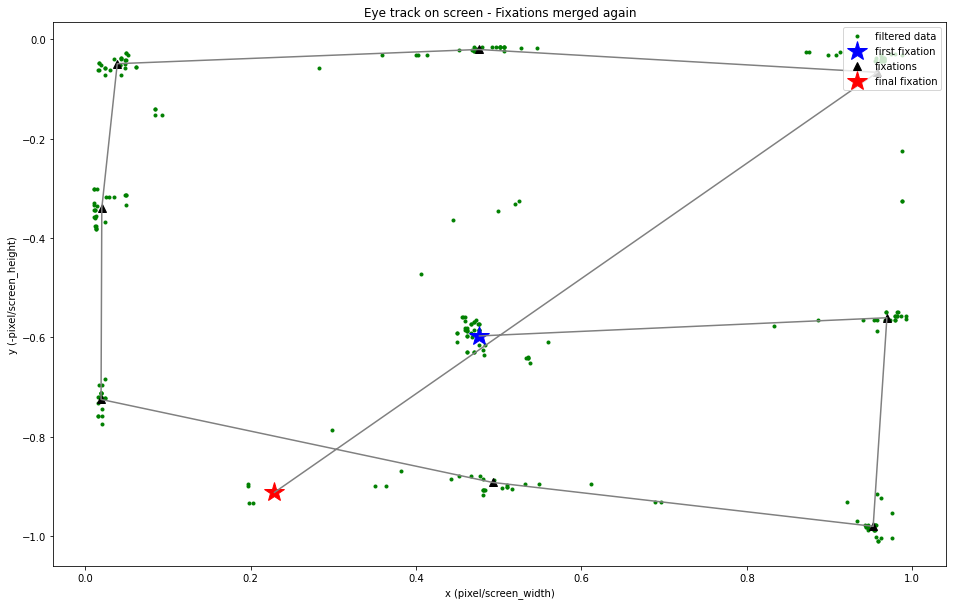

In [33]:
n_seq = 0
fms2_ind = []
fms2_x = []
fms2_y = []
for f in fix_mrg_two[n_seq]:
    fms2_ind.append(f[0])
    fms2_x.append(f[4])
    fms2_y.append(f[5])

plt.figure(figsize=(16, 10))
plt.plot(
    np.array(et_mat_in[n_seq][:, 0]),
    -np.array(et_mat_in[n_seq][:, 1]),
    'o', markersize=3,
    label="filtered data",
    color="green"
)
plt.plot(np.array(fms2_x[0]), -np.array(fms2_y[0]), '*', color='blue', markersize=20, label="first fixation")
plt.plot(np.array(fms2_x[1:-1]), -np.array(fms2_y[1:-1]), '^', label="fixations", color="black", markersize=8)
plt.plot(np.array(fms2_x[-1]), -np.array(fms2_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(fms2_x), -np.array(fms2_y), color='gray')
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Eye track on screen - Fixations merged again")
plt.legend(loc="upper right")

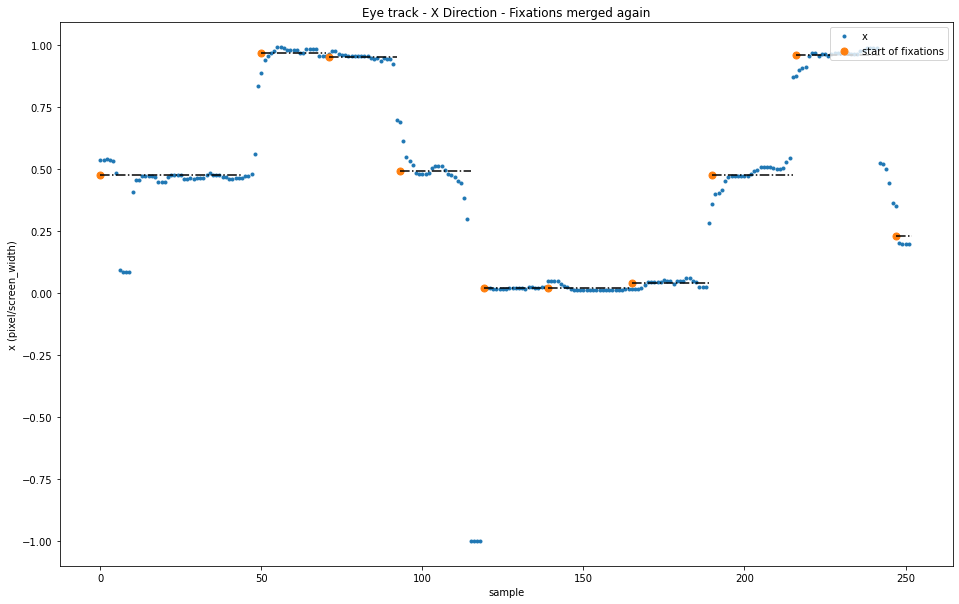

In [34]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 0], 'o', markersize=3, label="x")
plt.plot(fms2_ind, fms2_x, 'o', label="start of fixations", markersize=7)
for f in fix_mrg_two[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_x = np.ones(arf_ind.shape[0]) * f[4]
    plt.plot(arf_ind, arf_x, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - X Direction - Fixations merged again")
plt.xlabel("sample")
plt.ylabel("x (pixel/screen_width)")
plt.legend(loc="upper right")

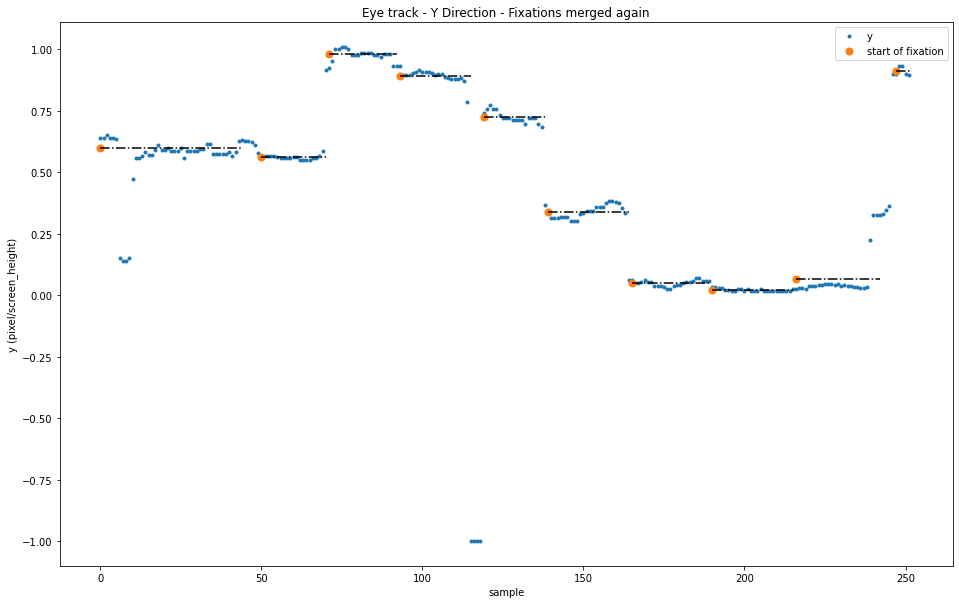

In [35]:
plt.figure(figsize=(16, 10))
plt.plot(et_mat_seq[n_seq][:, 1], 'o', markersize=3, label="y")
plt.plot(fms2_ind, fms2_y, 'o', label="start of fixation", markersize=7)
for f in fix_mrg_two[n_seq]:
    arf_ind = np.arange(f[0], f[0] + f[1] + 1)
    arf_y = np.ones(arf_ind.shape[0]) * f[5]
    plt.plot(arf_ind, arf_y, linestyle='-.',color="black", linewidth=1.5)
plt.title("Eye track - Y Direction - Fixations merged again")
plt.xlabel("sample")
plt.ylabel("y (pixel/screen_height)")
plt.legend(loc="upper right")

In [36]:
aoi = [[[0, 0], [0.33, 0.33]], [[0.33, 0], [0.66, 0.33]], [[0.66, 0], [1, 0.33]],
      [[0, 0.33], [0.33, 0.66]], [[0.33, 0.33], [0.66, 0.66]], [[0.66, 0.33], [1, 0.66]],
      [[0, 0.66], [0.33, 1]], [[0.33, 0.66], [0.66, 1]], [[0.66, 0.66], [1, 1]]]

In [37]:
a1 = np.array([2, 3])
a1 = np.insert(a1, 0, 10)
print(a1)

[10  2  3]


In [38]:
fix_aoi = []
for fix_mrg1 in fix_mrg_two:
    fix_aoi1 = []
    for f in fix_mrg1:
        f1 = f.copy()
        xm = f[4]
        ym = f[5]
        for (i, a) in enumerate(aoi):
            if (a[0][0] < xm) and (a[1][0] > xm) and (a[0][1] < ym) and (a[1][1] > ym):
                f1 = np.insert(f1, 0, i+1)
        fix_aoi1.append(f1)
    fix_aoi.append(np.array(fix_aoi1))

In [39]:
fs_in_aoi = np.zeros((9, 2))
for fix_aoi1 in fix_aoi:
    for f in fix_aoi1:
        fs_in_aoi[int(f[0]-1), 0] = fs_in_aoi[int(f[0]-1), 0] + 1
        fs_in_aoi[int(f[0]-1), 1] = fs_in_aoi[int(f[0]-1), 1] + f[4]

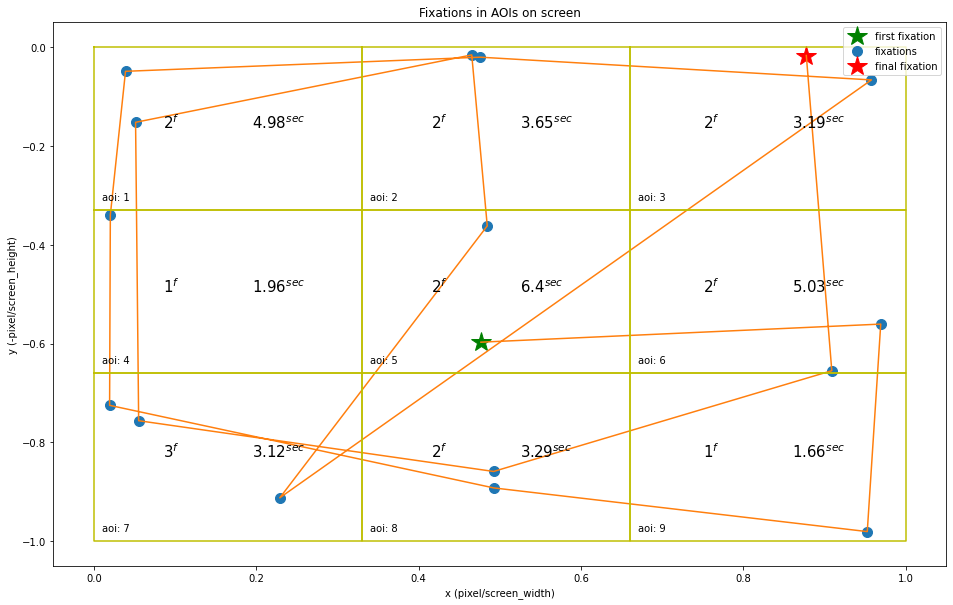

In [40]:
n_seq = 0
ff_ind = []
ff_x = []
ff_y = []
for f1 in fix_aoi:
    for f in f1:
        ff_ind.append(f[1])
        ff_x.append(f[5])
        ff_y.append(f[6])

plt.figure(figsize=(16, 10))
plt.plot(np.array(ff_x[0]), -np.array(ff_y[0]), '*', color='green', markersize=20, label="first fixation")
plt.plot(np.array(ff_x[1:-1]), -np.array(ff_y[1:-1]), 'o', label="fixations", markersize=10)
plt.plot(np.array(ff_x[-1]), -np.array(ff_y[-1]), '*', color='r', markersize=20, label="final fixation")
plt.plot(np.array(ff_x), -np.array(ff_y))
for (i, a) in enumerate(aoi):
    box_x = [a[0][0], a[0][0], a[1][0], a[1][0], a[0][0]]
    box_y = [a[0][1], a[1][1], a[1][1], a[0][1], a[0][1]]
    plt.plot(np.array(box_x), -np.array(box_y), color="y")
    plt.text(box_x[1]+0.01, -box_y[1]+0.02, "aoi: " + f"{i+1}")
    plt.text((box_x[0]+box_x[2])/2-0.08, -(box_y[0]+box_y[2])/2, str(round(fs_in_aoi[i, 0]))+r"$^f$", fontsize=15)
    plt.text((box_x[0]+box_x[2])/2+0.03, -(box_y[0]+box_y[2])/2, str(round(fs_in_aoi[i, 1], 2))+r"$^{sec}$", fontsize=15)
plt.xlabel("x (pixel/screen_width)")
plt.ylabel("y (-pixel/screen_height)")
plt.title("Fixations in AOIs on screen")
plt.legend(loc="upper right")